
=== Rolling Day 2025-01-02 ===
  Loading models for cutoff 2024-08-01 / 2024-12-31
  Forecast next 30 days from 2025-01-02 with noise
[PyTorch] Loading existing LSTM from ./best_LSTM_2025-01-02_V1.pt
[PyTorch] Loading existing GRU from ./best_GRU_2025-01-02_V1.pt
[PyTorch] Loading existing RNN from ./best_RNN_2025-01-02_V1.pt
[PyTorch] Loading existing CNN from ./best_CNN_2025-01-02_V1.pt
[PyTorch] Loading existing Transformer from ./best_Transformer_2025-01-02_V1.pt
[PyTorch] Loading existing N-BEATS from ./best_N-BEATS_2025-01-02_V1.pt
[PyTorch] Loading existing N-HITS from ./best_N-HITS_2025-01-02_V1.pt
[sklearn] Loading SVM => ./best_SVM_2025-01-02_V1.pkl
[sklearn] Loading Boost => ./best_Boost_2025-01-02_V1.pkl
  Actual price: 29.9000

=== Rolling Day 2025-01-03 ===
  Loading models for cutoff 2024-08-02 / 2025-01-01
  Forecast next 30 days from 2025-01-03 with noise
[PyTorch] Loading existing LSTM from ./best_LSTM_2025-01-03_V1.pt
[PyTorch] Loading existing GRU from ./best_GRU_2

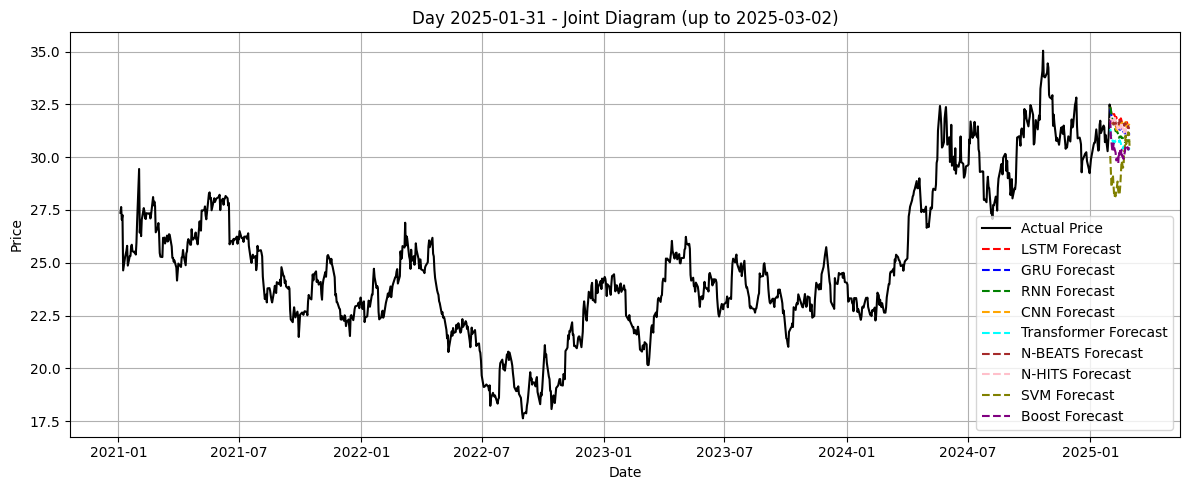

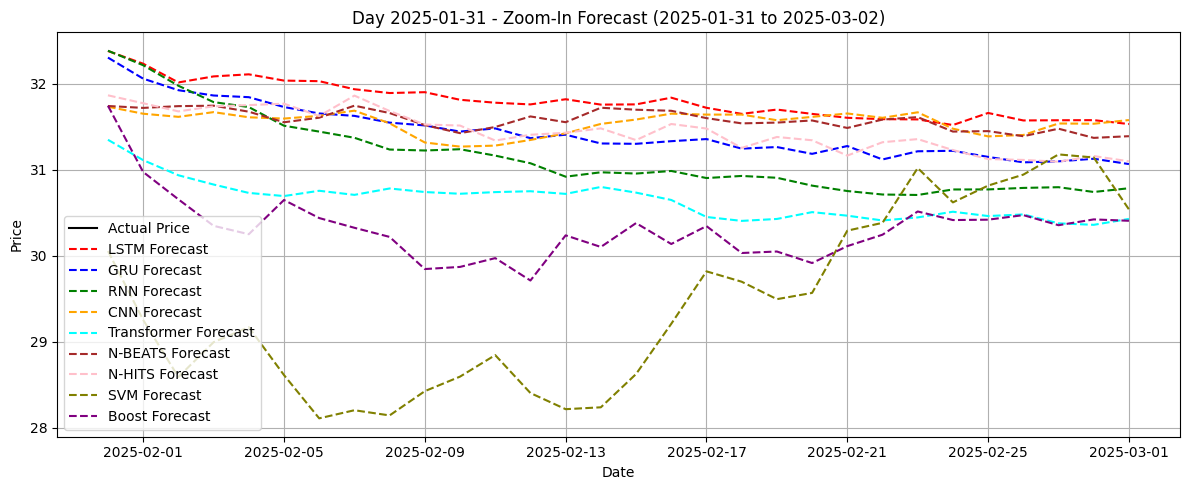


===== ROLLING FC HEAD =====
    ForecastDate  Pred_Price_unscaled  Pred_Open_unscaled  Pred_High_unscaled  \
240   2025-01-02            28.994883           29.438478           29.544843   
241   2025-01-03            29.306379           28.855274           29.319309   
242   2025-01-04            29.339579           29.230506           29.657818   
243   2025-01-05            29.093368           29.520648           29.542958   
244   2025-01-06            28.987211           29.033200           29.635805   
245   2025-01-07            29.262831           28.869210           29.359278   
246   2025-01-08            29.582209           29.240636           29.603759   
247   2025-01-09            30.204626           29.462123           29.994271   
248   2025-01-10            29.947314           29.620323           30.397042   
249   2025-01-11            30.353213           29.735842           30.929594   
250   2025-01-12            30.251933           30.193019           30.824608   

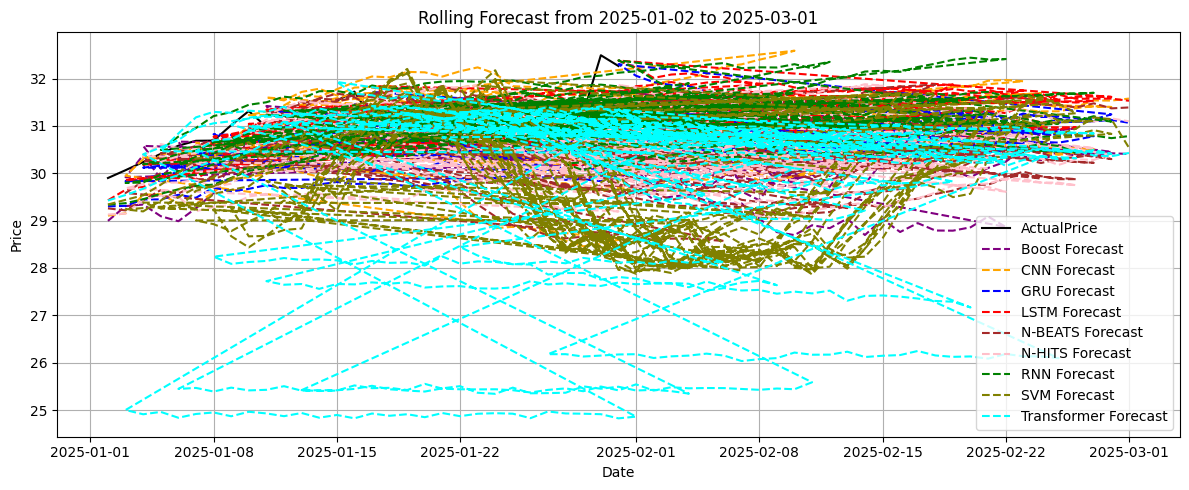

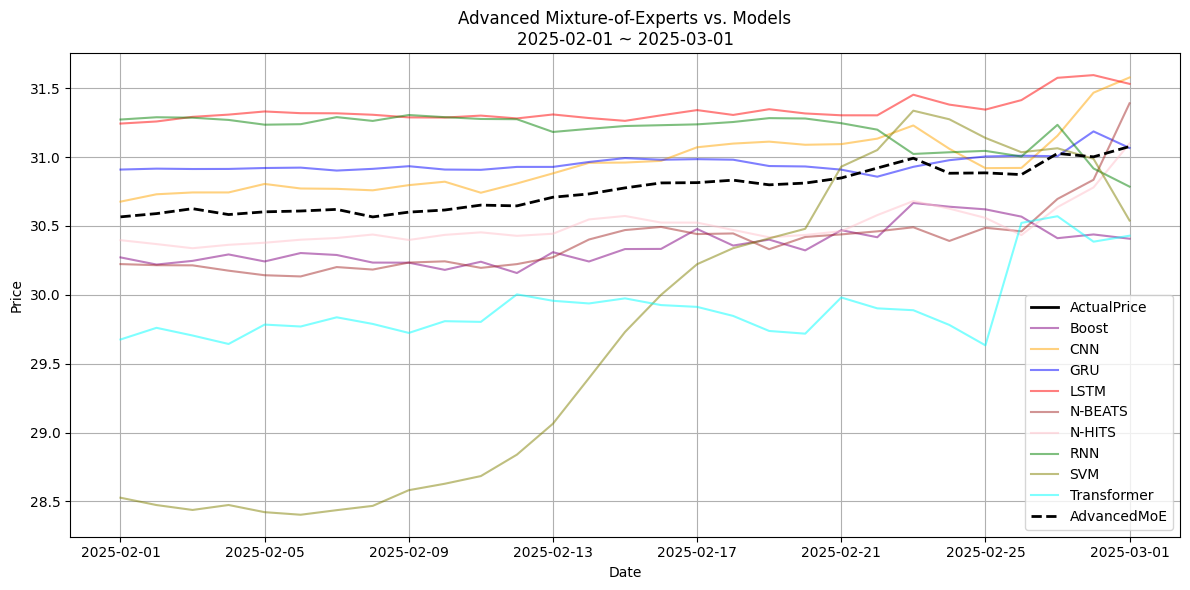

Advanced MoE done and plotted!


In [16]:
############################################
# Integrated Code: Main Skeleton + Advanced MoE
############################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import random
import joblib
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

# For final zoom-in diagrams
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

############################################
# 1. GLOBAL SETTINGS
############################################
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
features = ["Price", "Open", "High", "Low"]
WINDOW_SIZE = 35
NUM_EPOCHS = 1500
BEST_MODELS_DIR = "."  # Directory with your .pt/.pkl model files

############################################
# 2. Basic Data Preprocessing
############################################
def load_and_scale_data(train_csv, complete_csv):
    df_trainval = pd.read_csv(train_csv)
    df_trainval["Date"] = pd.to_datetime(df_trainval["Date"], errors="coerce")
    for col in ["Vol.", "Change %"]:
        if col in df_trainval.columns:
            df_trainval.drop(columns=[col], errors="ignore", inplace=True)
    for c in features:
        if c not in df_trainval.columns:
            df_trainval[c] = np.nan
        else:
            df_trainval[c] = df_trainval[c].astype(str).str.replace(",", "", regex=True)
            df_trainval[c] = pd.to_numeric(df_trainval[c], errors="coerce")
    df_trainval.sort_values("Date", inplace=True)
    df_trainval.reset_index(drop=True, inplace=True)
    train_cutoff = pd.to_datetime("2024-08-01")
    val_cutoff   = pd.to_datetime("2024-12-31")
    test_cutoff  = pd.to_datetime("2025-01-01")
    df_train = df_trainval[df_trainval["Date"] < train_cutoff].copy()
    df_val   = df_trainval[(df_trainval["Date"] >= train_cutoff) & (df_trainval["Date"] <= val_cutoff)].copy()
    df_test  = df_trainval[df_trainval["Date"] >= test_cutoff].copy()
    df_train_nonan = df_train.dropna(subset=features)
    scaler = MinMaxScaler()
    scaler.fit(df_train_nonan[features])
    df_train_scaled = df_train.copy()
    if not df_train_nonan.empty:
        df_train_scaled.loc[df_train_nonan.index, features] = scaler.transform(df_train_nonan[features])
    df_val_scaled = df_val.copy()
    val_no_nan = df_val_scaled.dropna(subset=features)
    if not val_no_nan.empty:
        df_val_scaled.loc[val_no_nan.index, features] = scaler.transform(val_no_nan[features])
    df_test_scaled = df_test.copy()
    train_mins = df_train_nonan[features].min()
    df_test_filled = df_test_scaled[features].fillna(train_mins)
    df_test_scaled.loc[:, features] = scaler.transform(df_test_filled)
    df_scaled = pd.concat([df_train_scaled, df_val_scaled, df_test_scaled], ignore_index=True)
    # Load complete CSV for final rolling
    df_complete = pd.read_csv(complete_csv)
    df_complete["Date"] = pd.to_datetime(df_complete["Date"], errors="coerce")
    for c in ["Vol.", "Change %"]:
        if c in df_complete.columns:
            df_complete.drop(columns=[c], inplace=True)
    for f in features:
        df_complete[f] = df_complete[f].astype(str).str.replace(",", "", regex=True).astype(float)
    df_complete.sort_values("Date", inplace=True)
    df_complete.reset_index(drop=True, inplace=True)
    return df_scaled, df_complete, scaler

############################################
# 3. Utility: Sequence & Slices
############################################
def make_sequences(df_subset, window=35):
    arr = df_subset[features].values
    dts = df_subset["Date"].values
    X_list, y_list, date_list = [], [], []
    for i in range(window, len(arr)):
        X_window = arr[i - window : i]
        y_target = arr[i]
        X_list.append(X_window)
        y_list.append(y_target)
        date_list.append(dts[i])
    return np.array(X_list), np.array(y_list), np.array(date_list)

############################################
# 4. Model Definitions
############################################
class BaseModel(nn.Module):
    def __init__(self, model_type="LSTM", window_width=35):
        super().__init__()
        self.model_type = model_type
        if model_type == "CNN":
            self.conv1 = nn.Conv1d(4, 64, 3)
            self.conv2 = nn.Conv1d(64, 128, 3)
            with torch.no_grad():
                dummy = torch.zeros(1, 4, window_width)
                outdummy = self.conv2(F.relu(self.conv1(dummy)))
                conv_output_size = outdummy.shape[1] * outdummy.shape[2]
            self.fc = nn.Linear(conv_output_size, 4)
        elif model_type == "LSTM":
            self.rnn = nn.LSTM(4, 128, num_layers=2, batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)
        elif model_type == "GRU":
            self.rnn = nn.GRU(4, 128, num_layers=2, batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)
        elif model_type == "RNN":
            self.rnn = nn.RNN(4, 128, num_layers=2, nonlinearity="relu", batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)
        elif model_type == "EnhancedLSTM":
            self.rnn = nn.LSTM(4, 128, num_layers=3, batch_first=True, dropout=0.1)
            self.bn = nn.BatchNorm1d(128)
            self.dropout = nn.Dropout(0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "Transformer":
            self.input_linear = nn.Linear(4, 128)
            encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, dropout=0.05)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
            self.fc = nn.Linear(128, 4)
        elif model_type in ["N-BEATS", "N-HITS"]:
            self.input_size = window_width * 4
            self.blocks = nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 4)
            ) for _ in range(3)])
        else:
            raise ValueError(f"Invalid model_type: {model_type}")

    def forward(self, x):
        if self.model_type == "CNN":
            x = x.permute(0, 2, 1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            return self.fc(x)
        elif self.model_type in ["LSTM", "GRU", "RNN"]:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            return self.fc(out)
        elif self.model_type == "EnhancedLSTM":
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.bn(out)
            out = self.dropout(out)
            return self.fc(out)
        elif self.model_type == "Transformer":
            x = self.input_linear(x)
            x = x.permute(1, 0, 2)
            x = self.transformer_encoder(x)
            x = x[-1, :, :]
            return self.fc(x)
        elif self.model_type in ["N-BEATS", "N-HITS"]:
            xflat = x.reshape(x.size(0), -1)
            forecast = 0
            for block in self.blocks:
                forecast += block(xflat)
            return forecast
        else:
            raise ValueError("Invalid model_type")

############################################
# 5. Model Loading (No training)
############################################
class SklearnWrapper:
    def __init__(self, model):
        self.model = model
    def forward(self, x):
        arr = x.cpu().numpy().reshape(1, -1)
        pred = self.model.predict(arr)
        return torch.from_numpy(pred).float().to(x.device)
    def eval(self):
        pass
    def __call__(self, x):
        return self.forward(x)

def load_torch_model(model_type, window_size, model_save_name):
    if not os.path.exists(model_save_name):
        raise FileNotFoundError(f"File not found: {model_save_name}")
    print(f"[PyTorch] Loading existing {model_type} from {model_save_name}")
    net = BaseModel(model_type, window_size).to(device)
    net.load_state_dict(torch.load(model_save_name, map_location=device))
    net.eval()
    return net

def load_sklearn_model(model_type, model_save_name):
    if not os.path.exists(model_save_name):
        raise FileNotFoundError(f"File not found: {model_save_name}")
    print(f"[sklearn] Loading {model_type} => {model_save_name}")
    loaded = joblib.load(model_save_name)
    return SklearnWrapper(loaded)

############################################
# 6. Forecasting Utilities
############################################
def get_latest_window(df_actual, current_date, window=35, scaler=None):
    mask = df_actual["Date"] < current_date
    df_sub = df_actual.loc[mask].copy()
    df_sub.sort_values("Date", inplace=True)
    if len(df_sub) < window:
        return None
    df_sub[features] = df_sub[features].fillna(method="ffill").fillna(method="bfill")
    arr = scaler.transform(df_sub[features].iloc[-window:].values)
    return arr

def forecast_n_days_from_date(model, df_actual, start_date, window=35, horizon=30,
                              device=None, scaler=None, noise_std=0.05):
    """
    Full-blind forecast with random noise each day.
    """
    def add_noise_4d(pred_unscaled, std=0.005):
        noise = np.random.normal(0.0, std, size=pred_unscaled.shape)
        return np.clip(pred_unscaled + noise, a_min=0, a_max=None)
    arr_window = get_latest_window(df_actual, start_date, window, scaler)
    if arr_window is None:
        return pd.DataFrame()
    rolling_buffer = np.copy(arr_window)
    forecast_records = []
    current_date = pd.to_datetime(start_date)
    for i in range(horizon):
        X_input = torch.tensor(rolling_buffer, dtype=torch.float).unsqueeze(0).to(device)
        with torch.no_grad():
            pred_scaled = model(X_input).cpu().numpy()[0]
        pred_unscaled = scaler.inverse_transform(pred_scaled.reshape(1, -1))[0]
        pred_noisy = add_noise_4d(pred_unscaled, noise_std)
        dayx = current_date + pd.Timedelta(days=i)
        forecast_records.append({
            "ForecastDate": dayx,
            "Pred_Price_unscaled": pred_noisy[0],
            "Pred_Open_unscaled": pred_noisy[1],
            "Pred_High_unscaled": pred_noisy[2],
            "Pred_Low_unscaled": pred_noisy[3]
        })
        pred_noisy_scaled = scaler.transform(pred_noisy.reshape(1, -1))[0]
        rolling_buffer = np.vstack([rolling_buffer[1:], pred_noisy_scaled.reshape(1, -1)])
    return pd.DataFrame(forecast_records)

############################################
# 7. Rolling Approach (LOAD Only)
############################################
def plot_daily_two_charts(day_i, horizon_days, daily_fcst_dict, df_actual):
    """
    Creates two plots for a given day_i:
      (1) Joint Diagram (up to day_i+horizon_days)
      (2) Zoom-In Diagram (from day_i to day_i+horizon_days)
    """
    df_sorted = df_actual.copy()
    df_sorted.sort_values("Date", inplace=True)
    day_end = day_i + pd.Timedelta(days=horizon_days)
    mask = (df_sorted["Date"] <= day_end)
    df_plot = df_sorted.loc[mask].copy()
    # Joint Diagram
    plt.figure(figsize=(12,5))
    plt.plot(df_plot["Date"], df_plot["Price"], color="black", label="Actual Price")
    color_map = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }
    for mname, fcdf in daily_fcst_dict.items():
        sub = fcdf[fcdf["ForecastDate"] <= day_end].copy()
        if not sub.empty:
            plt.plot(sub["ForecastDate"], sub["Pred_Price_unscaled"],
                     color=color_map.get(mname, "gray"), linestyle="--", label=f"{mname} Forecast")
    plt.title(f"Day {day_i.date()} - Joint Diagram (up to {day_end.date()})")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # Zoom-In Diagram
    plt.figure(figsize=(12,5))
    maskz = (df_plot["Date"] >= day_i) & (df_plot["Date"] <= day_end)
    df_zoom = df_plot.loc[maskz].copy()
    if not df_zoom.empty:
        plt.plot(df_zoom["Date"], df_zoom["Price"], color="black", label="Actual Price")
    for mname, fcdf in daily_fcst_dict.items():
        sub = fcdf[(fcdf["ForecastDate"] >= day_i) & (fcdf["ForecastDate"] <= day_end)]
        if not sub.empty:
            plt.plot(sub["ForecastDate"], sub["Pred_Price_unscaled"],
                     color=color_map.get(mname, "gray"), linestyle="--", label=f"{mname} Forecast")
    plt.title(f"Day {day_i.date()} - Zoom-In Forecast ({day_i.date()} to {day_end.date()})")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def rolling_train_validate_predict_moe(
    df_full, scaler_obj, model_types,
    start_train_cutoff=pd.to_datetime("2024-08-01"),
    start_val_cutoff=pd.to_datetime("2024-12-31"),
    start_pred=pd.to_datetime("2025-01-02"),
    end_pred=pd.to_datetime("2025-01-31"),
    horizon_days=30,
    do_daily_plots=True
):
    """
    Loads each model from pre-saved files for each day in [start_pred..end_pred],
    produces forecasts and (only on final rolling day) daily plots.
    """
    df_sorted = df_full.copy()
    df_sorted.sort_values("Date", inplace=True)
    df_scaled_all = df_sorted.copy()
    df_scaled_all[features] = df_scaled_all[features].fillna(method="ffill").fillna(method="bfill")
    df_scaled_all[features] = scaler_obj.transform(df_scaled_all[features])
    date_range = pd.date_range(start_pred, end_pred, freq="D")
    all_records = []
    for i, day_i in enumerate(date_range):
        train_cutoff_i = start_train_cutoff + pd.Timedelta(days=i)
        val_cutoff_i   = start_val_cutoff   + pd.Timedelta(days=i)
        print(f"\n=== Rolling Day {day_i.date()} ===")
        print(f"  Loading models for cutoff {train_cutoff_i.date()} / {val_cutoff_i.date()}")
        print(f"  Forecast next {horizon_days} days from {day_i.date()} with noise")
        model_dict = {}
        for mt in model_types:
            out_file = f"best_{mt}_{day_i.strftime('%Y-%m-%d')}_V1"
            if mt in ["SVM","GPR","Boost"]:
                out_file += ".pkl"
                net = load_sklearn_model(mt, os.path.join(BEST_MODELS_DIR, out_file))
            else:
                out_file += ".pt"
                net = load_torch_model(mt, WINDOW_SIZE, os.path.join(BEST_MODELS_DIR, out_file))
            model_dict[mt] = net
        daily_fcst_dict = {}
        for mt, net in model_dict.items():
            df_fc = forecast_n_days_from_date(
                model=net, df_actual=df_sorted, start_date=day_i,
                window=WINDOW_SIZE, horizon=horizon_days,
                device=device, scaler=scaler_obj, noise_std=0.05
            )
            if not df_fc.empty:
                df_fc["BaseDate"] = day_i
                df_fc["Model"] = mt
                daily_fcst_dict[mt] = df_fc
                all_records.append(df_fc)
            else:
                daily_fcst_dict[mt] = pd.DataFrame()
        row_actual = df_sorted[df_sorted["Date"] == day_i]
        if not row_actual.empty:
            print(f"  Actual price: {row_actual['Price'].values[0]:.4f}")
        if do_daily_plots and (day_i == date_range[-1]):
            plot_daily_two_charts(day_i, horizon_days, daily_fcst_dict, df_sorted)
    df_all = pd.concat(all_records, ignore_index=True) if all_records else pd.DataFrame()
    df_all.sort_values(["Model", "BaseDate", "ForecastDate"], inplace=True)
    return df_all

############################################
# 8. Final Rolling Forecast Plot
############################################
def plot_final_rolling_fc(final_rolling_fcst, df_actual, from_d, to_d):
    if final_rolling_fcst.empty:
        print("No final rolling forecast data. Exiting.")
        return
    df_act = df_actual.copy()
    df_act.sort_values("Date", inplace=True)
    mask = (df_act["Date"] >= from_d) & (df_act["Date"] <= to_d)
    df_a = df_act[mask].copy()
    plt.figure(figsize=(12,5))
    plt.plot(df_a["Date"], df_a["Price"], color="black", label="ActualPrice")
    color_map = {
        "LSTM": "red", "GRU": "blue", "RNN": "green",
        "CNN": "orange", "EnhancedLSTM": "magenta",
        "Transformer": "cyan", "N-BEATS": "brown",
        "N-HITS": "pink", "SVM": "olive", "GPR": "teal", "Boost": "purple"
    }
    for m in final_rolling_fcst["Model"].unique():
        df_m = final_rolling_fcst[final_rolling_fcst["Model"] == m].copy()
        df_m = df_m[(df_m["ForecastDate"] >= from_d) & (df_m["ForecastDate"] <= to_d)]
        if not df_m.empty:
            plt.plot(df_m["ForecastDate"], df_m["Pred_Price_unscaled"],
                     color=color_map.get(m, "gray"), linestyle="--", label=f"{m} Forecast")
    plt.title(f"Rolling Forecast from {from_d.date()} to {to_d.date()}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

############################################
# 9. Helper Functions for Base Date Selection
############################################
def pick_every_10th_base_dates(base_dates):
    if len(base_dates) == 0:
        return []
    sorted_bases = sorted(base_dates)
    chosen = []
    first_bd = sorted_bases[0]
    for bd in sorted_bases:
        day_diff = (bd - first_bd).days
        if day_diff % 10 == 0:
            chosen.append(bd)
    if sorted_bases[-1] not in chosen:
        chosen.append(sorted_bases[-1])
    return sorted(chosen)

def pick_every_5th_base_dates(base_dates):
    if len(base_dates) == 0:
        return []
    sorted_bases = sorted(base_dates)
    chosen = []
    first_bd = sorted_bases[0]
    for bd in sorted_bases:
        day_diff = (bd - first_bd).days
        if day_diff % 5 == 0:
            chosen.append(bd)
    if sorted_bases[-1] not in chosen:
        chosen.append(sorted_bases[-1])
    return sorted(chosen)

############################################
# 10. Zoom-in Joint Diagram + Model-by-Model Plots
############################################
def plot_joint_10day_forecasts_zoom_in(final_rolling_fcst, df_actual, start_date_plot, end_date_plot):
    """
    Joint Diagram: Uses every 10th BaseDate and restricts y-axis to [28,33].
    """
    color_map = {
        "LSTM": "red", "GRU": "blue", "RNN": "green",
        "CNN": "orange", "EnhancedLSTM": "magenta", "Transformer": "cyan",
        "N-BEATS": "brown", "N-HITS": "pink", "SVM": "olive", "GPR": "teal", "Boost": "purple"
    }
    df_plot = df_actual[(df_actual["Date"] >= start_date_plot) & (df_actual["Date"] <= end_date_plot)].copy()
    base_dates = pick_every_10th_base_dates(final_rolling_fcst["BaseDate"].unique())
    plt.figure(figsize=(12,6))
    plt.plot(df_plot["Date"], df_plot["Price"], color="black", lw=2, label="Actual Price")
    for m in final_rolling_fcst["Model"].unique():
        df_m = final_rolling_fcst[final_rolling_fcst["Model"] == m].copy()
        c = color_map.get(m, "gray")
        for bd in base_dates:
            df_bd = df_m[df_m["BaseDate"] == bd].copy()
            df_bd = df_bd[(df_bd["ForecastDate"] >= start_date_plot) & (df_bd["ForecastDate"] <= end_date_plot)]
            if len(df_bd) == 0:
                continue
            plt.plot(df_bd["ForecastDate"], df_bd["Pred_Price_unscaled"], color=c, alpha=0.4)
    legend_elems = [Line2D([0],[0], color="black", lw=2, label="Actual Price")]
    for m in final_rolling_fcst["Model"].unique():
        legend_elems.append(Line2D([0],[0], color=color_map.get(m, "gray"), lw=2, label=m))
    plt.legend(handles=legend_elems, loc="best")
    plt.ylim(28, 33)
    plt.title(f"Zoom-in Joint Diagram (Every 10th BaseDate)\n{start_date_plot.date()} ~ {end_date_plot.date()}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_each_model_10days(final_rolling_fcst, df_actual, start_date_plot, end_date_plot):
    """
    Model-by-model plot: Uses every 10th BaseDate.
    """
    models = sorted(final_rolling_fcst["Model"].unique())
    df_plot = df_actual[(df_actual["Date"] >= start_date_plot) & (df_actual["Date"] <= end_date_plot)].copy()
    base_dates = pick_every_10th_base_dates(final_rolling_fcst["BaseDate"].unique())
    for m in models:
        df_m = final_rolling_fcst[final_rolling_fcst["Model"] == m].copy()
        plt.figure(figsize=(10,5))
        plt.plot(df_plot["Date"], df_plot["Price"], color="black", lw=2, label="Actual Price")
        for bd in base_dates:
            df_bd = df_m[df_m["BaseDate"] == bd].copy()
            df_bd = df_bd[(df_bd["ForecastDate"] >= start_date_plot) & (df_bd["ForecastDate"] <= end_date_plot)]
            if len(df_bd) == 0:
                continue
            plt.plot(df_bd["ForecastDate"], df_bd["Pred_Price_unscaled"], alpha=0.6)
        plt.title(f"{m}: Rolling Forecast (Every 10th BaseDate)")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

def plot_each_model_5days(final_rolling_fcst, df_actual, start_date_plot, end_date_plot):
    """
    Model-by-model plot: Uses every 5th BaseDate.
    """
    models = sorted(final_rolling_fcst["Model"].unique())
    df_plot = df_actual[(df_actual["Date"] >= start_date_plot) & (df_actual["Date"] <= end_date_plot)].copy()
    base_dates = pick_every_5th_base_dates(final_rolling_fcst["BaseDate"].unique())
    for m in models:
        df_m = final_rolling_fcst[final_rolling_fcst["Model"] == m].copy()
        plt.figure(figsize=(10,5))
        plt.plot(df_plot["Date"], df_plot["Price"], color="black", lw=2, label="Actual Price")
        for bd in base_dates:
            df_bd = df_m[df_m["BaseDate"] == bd].copy()
            df_bd = df_bd[(df_bd["ForecastDate"] >= start_date_plot) & (df_bd["ForecastDate"] <= end_date_plot)]
            if len(df_bd) == 0:
                continue
            plt.plot(df_bd["ForecastDate"], df_bd["Pred_Price_unscaled"], alpha=0.6)
        plt.title(f"{m}: Rolling Forecast (Every 5th BaseDate)")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

############################################
# 11. Advanced Mixture-of-Experts (MoE)
############################################
# A) Evaluate January performance and volatility
def compute_january_performance(final_rolling_fcst, df_actual):
    start_jan = pd.to_datetime("2025-01-01")
    end_jan = pd.to_datetime("2025-01-31")
    df_jan_pred = final_rolling_fcst[(final_rolling_fcst["ForecastDate"] >= start_jan) & 
                                     (final_rolling_fcst["ForecastDate"] <= end_jan)].copy()
    df_act_jan = df_actual[(df_actual["Date"] >= start_jan) & (df_actual["Date"] <= end_jan)].copy()
    df_act_jan.rename(columns={"Date": "ForecastDate", "Price": "ActualPrice"}, inplace=True)
    df_merge = pd.merge(df_jan_pred[["Model", "ForecastDate", "Pred_Price_unscaled"]],
                        df_act_jan[["ForecastDate", "ActualPrice"]],
                        on="ForecastDate", how="inner")
    if df_merge.empty:
        all_models = final_rolling_fcst["Model"].unique()
        return ({m: 0.0 for m in all_models},
                {m: 1.0 for m in all_models},
                {m: 1.0 for m in all_models},
                1.0)
    df_merge["AbsError"] = (df_merge["Pred_Price_unscaled"] - df_merge["ActualPrice"]).abs()
    g = df_merge.groupby("Model")["AbsError"].mean()
    model_mae = dict(g)
    mae_min = g.min()
    mae_max = g.max()
    base_acc = {}
    if np.isclose(mae_min, mae_max):
        for m in g.index:
            base_acc[m] = 1.0
    else:
        for m, e in g.items():
            base_acc[m] = 1.0 - ((e - mae_min) / (mae_max - mae_min))
    df_jan_pred_agg = df_jan_pred.groupby(["Model", "ForecastDate"], as_index=False)["Pred_Price_unscaled"].mean()
    df_jan_pred_agg.sort_values(["Model", "ForecastDate"], inplace=True)
    model_vol = {}
    for m in df_jan_pred_agg["Model"].unique():
        sub = df_jan_pred_agg[df_jan_pred_agg["Model"] == m].copy()
        sub.sort_values("ForecastDate", inplace=True)
        sub["DayChange"] = sub["Pred_Price_unscaled"].diff()
        std_ = sub["DayChange"].std(skipna=True)
        if pd.isna(std_):
            std_ = 0.01
        model_vol[m] = float(std_)
    df_act_jan_sorted = df_act_jan.drop_duplicates("ForecastDate").copy()
    df_act_jan_sorted.sort_values("ForecastDate", inplace=True)
    df_act_jan_sorted["DayChange"] = df_act_jan_sorted["ActualPrice"].diff()
    real_vol = df_act_jan_sorted["DayChange"].std(skipna=True)
    if pd.isna(real_vol) or np.isclose(real_vol, 0):
        real_vol = 0.01
    return model_mae, base_acc, model_vol, real_vol

# B) Trend Consistency and Direction Factor
def compute_trend_consistency(final_rolling_fcst, forecast_day, model_name):
    df_m = final_rolling_fcst[(final_rolling_fcst["Model"] == model_name) &
                              (final_rolling_fcst["ForecastDate"] == forecast_day)]
    preds = df_m["Pred_Price_unscaled"].values
    if len(preds) <= 1:
        return 1.0
    std_ = np.std(preds)
    return 1.0 / (1.0 + std_)

def compute_direction_factor(final_rolling_fcst, forecast_day, model_name):
    df_m = final_rolling_fcst[(final_rolling_fcst["Model"] == model_name) &
                              (final_rolling_fcst["ForecastDate"] == forecast_day)].copy()
    if df_m.empty:
        return 1.0
    d_prev = forecast_day - pd.Timedelta(days=1)
    directions = []
    for base_d in df_m["BaseDate"].unique():
        p_d = df_m[df_m["BaseDate"] == base_d]["Pred_Price_unscaled"].values[0]
        df_prev = final_rolling_fcst[(final_rolling_fcst["Model"] == model_name) &
                                     (final_rolling_fcst["BaseDate"] == base_d) &
                                     (final_rolling_fcst["ForecastDate"] == d_prev)]
        if df_prev.empty:
            continue
        p_dprev = df_prev["Pred_Price_unscaled"].values[0]
        if p_d > p_dprev:
            directions.append(1)
        elif p_d < p_dprev:
            directions.append(-1)
        else:
            directions.append(0)
    if not directions:
        return 1.0
    directions = np.array(directions)
    ups = np.sum(directions > 0)
    downs = np.sum(directions < 0)
    total = len(directions)
    ratio = abs(ups - downs) / float(total)
    return 0.5 + 0.5 * ratio

def volatility_alignment_factor(m_vol, r_vol):
    ratio = m_vol / r_vol
    return np.exp(-abs(ratio - 1.0))

# C) Advanced MoE Computation
def compute_advanced_moe(final_rolling_fcst, df_actual):
    model_mae, base_acc, model_vol, real_vol = compute_january_performance(final_rolling_fcst, df_actual)
    start_moe = pd.to_datetime("2025-02-01")
    end_moe = pd.to_datetime("2025-03-01")
    all_days = pd.date_range(start_moe, end_moe, freq="D")
    all_models = final_rolling_fcst["Model"].unique()
    moe_records = []
    for d in all_days:
        daily_model_prices = {}
        for m in all_models:
            df_m = final_rolling_fcst[(final_rolling_fcst["Model"] == m) &
                                      (final_rolling_fcst["ForecastDate"] == d)]
            if df_m.empty:
                continue
            pred_mean = df_m["Pred_Price_unscaled"].mean()
            daily_model_prices[m] = pred_mean
        if not daily_model_prices:
            continue
        weights = {}
        for m, pred_price in daily_model_prices.items():
            w1 = base_acc.get(m, 0.5)
            w2 = compute_trend_consistency(final_rolling_fcst, d, m)
            w3 = compute_direction_factor(final_rolling_fcst, d, m)
            mvol = model_vol.get(m, 0.01)
            w4 = volatility_alignment_factor(mvol, real_vol)
            weights[m] = w1 * w2 * w3 * w4
        sw = sum(weights.values())
        if np.isclose(sw, 0.0):
            moe_price = np.mean(list(daily_model_prices.values()))
        else:
            moe_price = np.sum([ (weights[m]/sw)*daily_model_prices[m] for m in daily_model_prices ])
        moe_records.append({"ForecastDate": d, "MOE_Price": moe_price})
    df_moe = pd.DataFrame(moe_records)
    df_moe.sort_values("ForecastDate", inplace=True)
    return df_moe

# D) Plot Advanced MoE vs Models
def plot_advanced_moe_vs_models(final_rolling_fcst, df_moe, df_actual,
                                start_plot=pd.to_datetime("2025-02-01"),
                                end_plot=pd.to_datetime("2025-03-01")):
    df_act = df_actual[(df_actual["Date"] >= start_plot) & (df_actual["Date"] <= end_plot)].copy()
    df_act.sort_values("Date", inplace=True)
    df_fc = final_rolling_fcst[(final_rolling_fcst["ForecastDate"] >= start_plot) &
                               (final_rolling_fcst["ForecastDate"] <= end_plot)].copy()
    plt.figure(figsize=(12,6))
    if not df_act.empty:
        plt.plot(df_act["Date"], df_act["Price"], color="black", label="ActualPrice", linewidth=2)
    color_map = {
        "LSTM": "red", "GRU": "blue", "RNN": "green",
        "CNN": "orange", "EnhancedLSTM": "magenta",
        "Transformer": "cyan", "N-BEATS": "brown",
        "N-HITS": "pink", "SVM": "olive", "GPR": "teal", "Boost": "purple"
    }
    for m in df_fc["Model"].unique():
        df_m = df_fc[df_fc["Model"] == m].copy()
        df_m_agg = df_m.groupby("ForecastDate", as_index=False)["Pred_Price_unscaled"].mean()
        c = color_map.get(m, "gray")
        plt.plot(df_m_agg["ForecastDate"], df_m_agg["Pred_Price_unscaled"], color=c, alpha=0.5, label=m)
    df_moe_sub = df_moe[(df_moe["ForecastDate"] >= start_plot) & (df_moe["ForecastDate"] <= end_plot)].copy()
    if not df_moe_sub.empty:
        plt.plot(df_moe_sub["ForecastDate"], df_moe_sub["MOE_Price"],
                 color="black", linestyle="--", linewidth=2, label="AdvancedMoE")
    plt.title(f"Advanced Mixture-of-Experts vs. Models\n{start_plot.date()} ~ {end_plot.date()}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

############################################
# 12. MAIN
############################################
if __name__=="__main__":
    # Main Code Skeleton
    df_scaled, df_complete_all, scaler = load_and_scale_data(
        "Silver Futures Historical Data.csv",
        "Silver Futures Historical Data_Complete.csv"
    )
    final_rolling_fc = rolling_train_validate_predict_moe(
        df_full = df_complete_all,
        scaler_obj = scaler,
        model_types = ["LSTM","GRU","RNN","CNN","Transformer","N-BEATS","N-HITS","SVM","Boost"],
        start_train_cutoff = pd.to_datetime("2024-08-01"),
        start_val_cutoff = pd.to_datetime("2024-12-31"),
        start_pred = pd.to_datetime("2025-01-02"),
        end_pred = pd.to_datetime("2025-01-31"),
        horizon_days = 30,
        do_daily_plots = True
    )
    # Plot final rolling forecast
    print("\n===== ROLLING FC HEAD =====")
    print(final_rolling_fc.head(50))
    plot_final_rolling_fc(
        final_rolling_fc,
        df_complete_all,
        from_d = pd.to_datetime("2025-01-02"),
        to_d = pd.to_datetime("2025-03-01")
    )
    # Create alias so MoE code uses expected name
    final_rolling_fcst = final_rolling_fc

    # Advanced Mixture-of-Experts
    df_moe_advanced = compute_advanced_moe(final_rolling_fcst, df_complete_all)
    plot_advanced_moe_vs_models(
        final_rolling_fcst,
        df_moe_advanced,
        df_complete_all,
        start_plot = pd.to_datetime("2025-02-01"),
        end_plot = pd.to_datetime("2025-03-01")
    )
    plt.show()
    print("Advanced MoE done and plotted!")



=== Rolling Day 2025-01-02 ===
  Loading models for cutoff 2024-08-01 / 2024-12-31
  Forecast next 30 days from 2025-01-02 with noise
[PyTorch] Loading existing LSTM from ./best_LSTM_2025-01-02_V1.pt
[PyTorch] Loading existing GRU from ./best_GRU_2025-01-02_V1.pt
[PyTorch] Loading existing RNN from ./best_RNN_2025-01-02_V1.pt
[PyTorch] Loading existing CNN from ./best_CNN_2025-01-02_V1.pt
[PyTorch] Loading existing Transformer from ./best_Transformer_2025-01-02_V1.pt
[PyTorch] Loading existing N-BEATS from ./best_N-BEATS_2025-01-02_V1.pt
[PyTorch] Loading existing N-HITS from ./best_N-HITS_2025-01-02_V1.pt
[sklearn] Loading SVM => ./best_SVM_2025-01-02_V1.pkl
[sklearn] Loading Boost => ./best_Boost_2025-01-02_V1.pkl
  Actual price: 29.9000

=== Rolling Day 2025-01-03 ===
  Loading models for cutoff 2024-08-02 / 2025-01-01
  Forecast next 30 days from 2025-01-03 with noise
[PyTorch] Loading existing LSTM from ./best_LSTM_2025-01-03_V1.pt
[PyTorch] Loading existing GRU from ./best_GRU_2

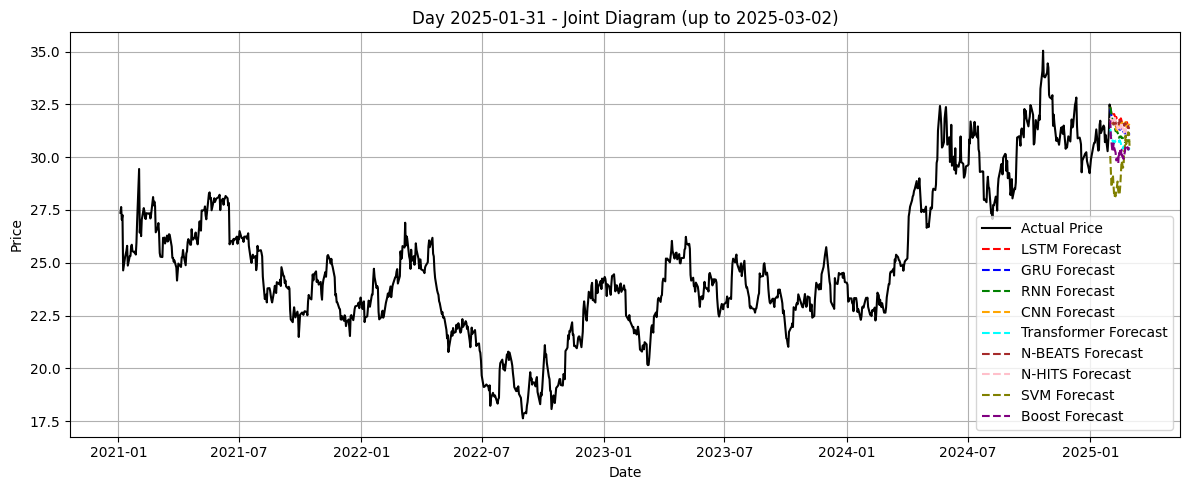

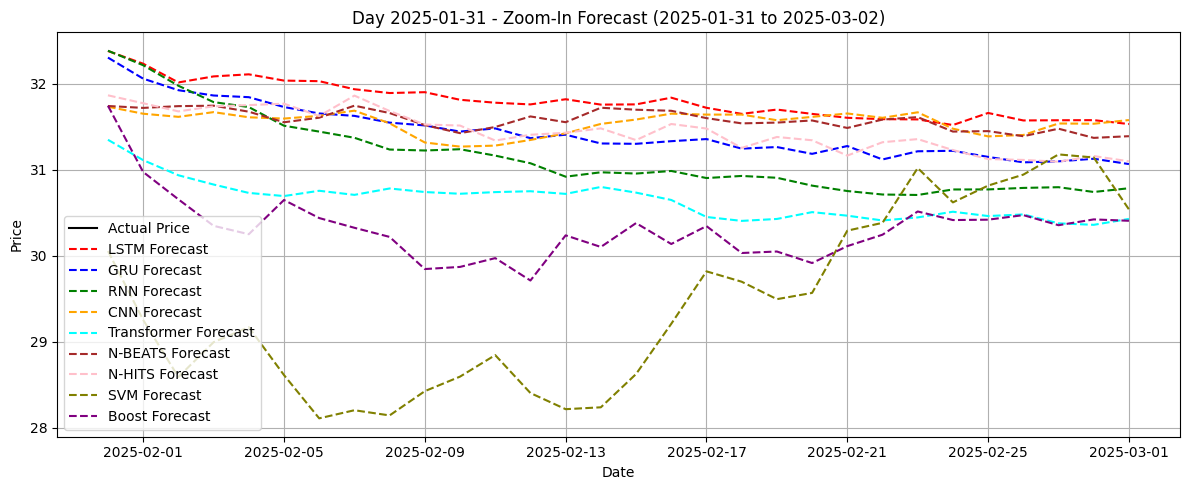


===== ROLLING FC HEAD =====
    ForecastDate  Pred_Price_unscaled  Pred_Open_unscaled  Pred_High_unscaled  \
240   2025-01-02            28.994883           29.438478           29.544843   
241   2025-01-03            29.306379           28.855274           29.319309   
242   2025-01-04            29.339579           29.230506           29.657818   
243   2025-01-05            29.093368           29.520648           29.542958   
244   2025-01-06            28.987211           29.033200           29.635805   
245   2025-01-07            29.262831           28.869210           29.359278   
246   2025-01-08            29.582209           29.240636           29.603759   
247   2025-01-09            30.204626           29.462123           29.994271   
248   2025-01-10            29.947314           29.620323           30.397042   
249   2025-01-11            30.353213           29.735842           30.929594   
250   2025-01-12            30.251933           30.193019           30.824608   

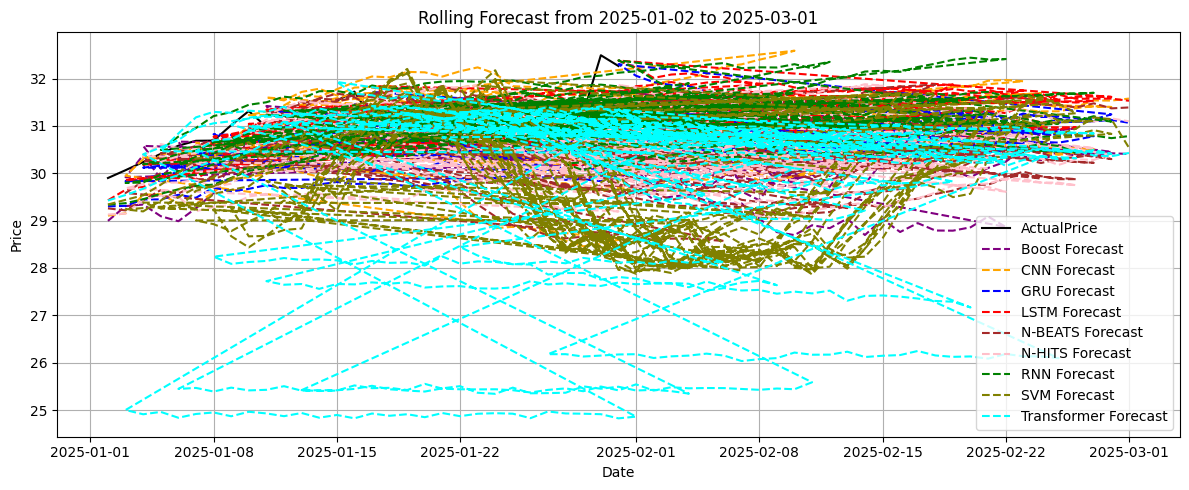


=== Advanced Mixture-of-Experts Implementation ===
1) We compute each model's base accuracy from January (MAE => normalized).
2) For each forecast day, we measure how consistent each model is (std dev across rolling base dates).
3) We also measure directional agreement (majority up or down).
4) We compare each model's January volatility to the real volatility => volatility alignment factor.
5) We combine these factors => final daily weight => Weighted sum => MoE.

Possible further ideas: polynomial slope analysis, random forest ensemble, partial voting logic, etc.



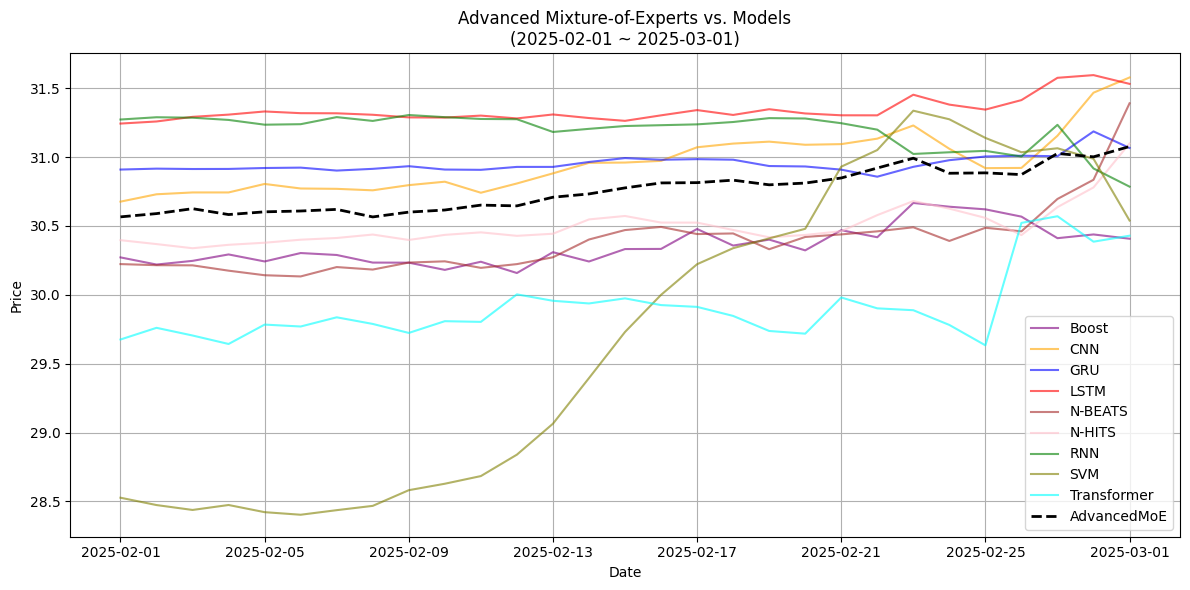

Advanced MoE done and plotted!


In [3]:
############################################
# Integrated Code: Main Skeleton + Advanced MoE
############################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import random
import joblib
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.dates as mdates
from matplotlib.lines import Line2D

############################################
# 1. GLOBAL SETTINGS
############################################
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
features = ["Price", "Open", "High", "Low"]
WINDOW_SIZE = 35
NUM_EPOCHS = 1500
BEST_MODELS_DIR = "."  # Directory with your .pt/.pkl model files

############################################
# 2. Basic Data Preprocessing
############################################
def load_and_scale_data(train_csv, complete_csv):
    df_trainval = pd.read_csv(train_csv)
    df_trainval["Date"] = pd.to_datetime(df_trainval["Date"], errors="coerce")
    for col in ["Vol.", "Change %"]:
        if col in df_trainval.columns:
            df_trainval.drop(columns=[col], errors="ignore", inplace=True)

    for c in features:
        if c not in df_trainval.columns:
            df_trainval[c] = np.nan
        else:
            df_trainval[c] = df_trainval[c].astype(str).str.replace(",", "", regex=True)
            df_trainval[c] = pd.to_numeric(df_trainval[c], errors="coerce")

    df_trainval.sort_values("Date", inplace=True)
    df_trainval.reset_index(drop=True, inplace=True)

    train_cutoff = pd.to_datetime("2024-08-01")
    val_cutoff   = pd.to_datetime("2024-12-31")
    test_cutoff  = pd.to_datetime("2025-01-01")

    df_train = df_trainval[df_trainval["Date"] < train_cutoff].copy()
    df_val   = df_trainval[(df_trainval["Date"] >= train_cutoff) & (df_trainval["Date"] <= val_cutoff)].copy()
    df_test  = df_trainval[df_trainval["Date"] >= test_cutoff].copy()

    df_train_nonan = df_train.dropna(subset=features)
    scaler = MinMaxScaler()
    scaler.fit(df_train_nonan[features])

    df_train_scaled = df_train.copy()
    if not df_train_nonan.empty:
        df_train_scaled.loc[df_train_nonan.index, features] = scaler.transform(df_train_nonan[features])

    df_val_scaled = df_val.copy()
    val_no_nan = df_val_scaled.dropna(subset=features)
    if not val_no_nan.empty:
        df_val_scaled.loc[val_no_nan.index, features] = scaler.transform(val_no_nan[features])

    df_test_scaled = df_test.copy()
    train_mins = df_train_nonan[features].min()
    df_test_filled = df_test_scaled[features].fillna(train_mins)
    df_test_scaled.loc[:, features] = scaler.transform(df_test_filled)

    df_scaled = pd.concat([df_train_scaled, df_val_scaled, df_test_scaled], ignore_index=True)

    # Load complete CSV for final rolling
    df_complete = pd.read_csv(complete_csv)
    df_complete["Date"] = pd.to_datetime(df_complete["Date"], errors="coerce")
    for c in ["Vol.", "Change %"]:
        if c in df_complete.columns:
            df_complete.drop(columns=[c], inplace=True)
    for f in features:
        df_complete[f] = df_complete[f].astype(str).str.replace(",", "", regex=True).astype(float)
    df_complete.sort_values("Date", inplace=True)
    df_complete.reset_index(drop=True, inplace=True)

    return df_scaled, df_complete, scaler

############################################
# 3. Utility: Sequence & Slices
############################################
def make_sequences(df_subset, window=35):
    arr = df_subset[features].values
    dts = df_subset["Date"].values
    X_list, y_list, date_list = [], [], []
    for i in range(window, len(arr)):
        X_window = arr[i - window : i]
        y_target = arr[i]
        X_list.append(X_window)
        y_list.append(y_target)
        date_list.append(dts[i])
    return np.array(X_list), np.array(y_list), np.array(date_list)

############################################
# 4. Model Definitions
############################################
class BaseModel(nn.Module):
    def __init__(self, model_type="LSTM", window_width=35):
        super().__init__()
        self.model_type = model_type

        if model_type == "CNN":
            self.conv1 = nn.Conv1d(4, 64, 3)
            self.conv2 = nn.Conv1d(64, 128, 3)
            with torch.no_grad():
                dummy = torch.zeros(1, 4, window_width)
                outdummy = self.conv2(F.relu(self.conv1(dummy)))
                conv_output_size = outdummy.shape[1]*outdummy.shape[2]
            self.fc = nn.Linear(conv_output_size, 4)

        elif model_type == "LSTM":
            self.rnn = nn.LSTM(4, 128, num_layers=2, batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "GRU":
            self.rnn = nn.GRU(4, 128, num_layers=2, batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "RNN":
            self.rnn = nn.RNN(4, 128, num_layers=2, nonlinearity="relu", batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "EnhancedLSTM":
            self.rnn = nn.LSTM(4, 128, num_layers=3, batch_first=True, dropout=0.1)
            self.bn  = nn.BatchNorm1d(128)
            self.dropout = nn.Dropout(0.1)
            self.fc = nn.Linear(128, 4)

        elif model_type == "Transformer":
            self.input_linear = nn.Linear(4, 128)
            encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, dropout=0.05)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
            self.fc = nn.Linear(128,4)

        elif model_type in ["N-BEATS","N-HITS"]:
            self.input_size= window_width*4
            self.blocks= nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size,128),
                nn.ReLU(),
                nn.Linear(128,128),
                nn.ReLU(),
                nn.Linear(128,4)
            ) for _ in range(3)])
        else:
            raise ValueError(f"Invalid model_type: {model_type}")

    def forward(self, x):
        if self.model_type == "CNN":
            x = x.permute(0,2,1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            return self.fc(x)

        elif self.model_type in ["LSTM","GRU","RNN"]:
            out, _ = self.rnn(x)
            out = out[:,-1,:]
            return self.fc(out)

        elif self.model_type == "EnhancedLSTM":
            out, _= self.rnn(x)
            out = out[:,-1,:]
            out = self.bn(out)
            out = self.dropout(out)
            return self.fc(out)

        elif self.model_type == "Transformer":
            x = self.input_linear(x)
            x = x.permute(1,0,2)
            x = self.transformer_encoder(x)
            x = x[-1,:,:]
            return self.fc(x)

        elif self.model_type in ["N-BEATS","N-HITS"]:
            xflat= x.reshape(x.size(0), -1)
            forecast=0
            for block in self.blocks:
                forecast += block(xflat)
            return forecast

        else:
            raise ValueError("Invalid model_type")

############################################
# 5. Model Loading (No training)
############################################
class SklearnWrapper:
    def __init__(self, model):
        self.model = model
    def forward(self, x):
        arr = x.cpu().numpy().reshape(1, -1)
        pred = self.model.predict(arr)
        return torch.from_numpy(pred).float().to(x.device)
    def eval(self):
        pass
    def __call__(self, x):
        return self.forward(x)

def load_torch_model(model_type, window_size, model_save_name):
    if not os.path.exists(model_save_name):
        raise FileNotFoundError(f"File not found: {model_save_name}")
    print(f"[PyTorch] Loading existing {model_type} from {model_save_name}")
    net = BaseModel(model_type, window_size).to(device)
    net.load_state_dict(torch.load(model_save_name, map_location=device))
    net.eval()
    return net

def load_sklearn_model(model_type, model_save_name):
    if not os.path.exists(model_save_name):
        raise FileNotFoundError(f"File not found: {model_save_name}")
    print(f"[sklearn] Loading {model_type} => {model_save_name}")
    loaded = joblib.load(model_save_name)
    return SklearnWrapper(loaded)

############################################
# 6. Forecasting Utilities
############################################
def get_latest_window(df_actual, current_date, window=35, scaler=None):
    mask = df_actual["Date"] < current_date
    df_sub = df_actual.loc[mask].copy()
    df_sub.sort_values("Date", inplace=True)
    if len(df_sub) < window:
        return None
    df_sub[features] = df_sub[features].fillna(method="ffill").fillna(method="bfill")
    arr = scaler.transform(df_sub[features].iloc[-window:].values)
    return arr

def forecast_n_days_from_date(model, df_actual, start_date, window=35, horizon=30,
                              device=None, scaler=None, noise_std=0.05):
    """
    Full-blind forecast with random noise each day.
    """
    def add_noise_4d(pred_unscaled, std=0.005):
        noise = np.random.normal(0.0, std, size=pred_unscaled.shape)
        return np.clip(pred_unscaled + noise, a_min=0, a_max=None)

    arr_window = get_latest_window(df_actual, start_date, window, scaler)
    if arr_window is None:
        return pd.DataFrame()

    rolling_buffer = np.copy(arr_window)
    forecast_records = []
    current_date = pd.to_datetime(start_date)

    for i in range(horizon):
        X_input = torch.tensor(rolling_buffer, dtype=torch.float).unsqueeze(0).to(device)
        with torch.no_grad():
            pred_scaled = model(X_input).cpu().numpy()[0]
        pred_unscaled = scaler.inverse_transform(pred_scaled.reshape(1, -1))[0]
        pred_noisy = add_noise_4d(pred_unscaled, noise_std)

        dayx = current_date + pd.Timedelta(days=i)
        forecast_records.append({
            "ForecastDate": dayx,
            "Pred_Price_unscaled": pred_noisy[0],
            "Pred_Open_unscaled": pred_noisy[1],
            "Pred_High_unscaled": pred_noisy[2],
            "Pred_Low_unscaled": pred_noisy[3]
        })

        pred_noisy_scaled = scaler.transform(pred_noisy.reshape(1, -1))[0]
        rolling_buffer = np.vstack([rolling_buffer[1:], pred_noisy_scaled.reshape(1, -1)])

    return pd.DataFrame(forecast_records)

############################################
# 7. Rolling Approach (LOAD Only)
############################################
def plot_daily_two_charts(day_i, horizon_days, daily_fcst_dict, df_actual):
    """
    Creates two plots for a given day_i:
      (1) Joint Diagram (up to day_i+horizon_days)
      (2) Zoom-In Diagram (from day_i to day_i+horizon_days)
    """
    df_sorted = df_actual.copy()
    df_sorted.sort_values("Date", inplace=True)
    day_end = day_i + pd.Timedelta(days=horizon_days)
    mask = (df_sorted["Date"] <= day_end)
    df_plot = df_sorted.loc[mask].copy()

    # Joint Diagram
    plt.figure(figsize=(12,5))
    plt.plot(df_plot["Date"], df_plot["Price"], color="black", label="Actual Price")

    color_map = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }
    for mname, fcdf in daily_fcst_dict.items():
        sub = fcdf[fcdf["ForecastDate"] <= day_end].copy()
        if not sub.empty:
            plt.plot(sub["ForecastDate"], sub["Pred_Price_unscaled"],
                     color=color_map.get(mname, "gray"), linestyle="--", label=f"{mname} Forecast")

    plt.title(f"Day {day_i.date()} - Joint Diagram (up to {day_end.date()})")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Zoom-In Diagram
    plt.figure(figsize=(12,5))
    maskz = (df_plot["Date"] >= day_i) & (df_plot["Date"] <= day_end)
    df_zoom = df_plot.loc[maskz].copy()
    if not df_zoom.empty:
        plt.plot(df_zoom["Date"], df_zoom["Price"], color="black", label="Actual Price")

    for mname, fcdf in daily_fcst_dict.items():
        sub = fcdf[(fcdf["ForecastDate"] >= day_i) & (fcdf["ForecastDate"] <= day_end)]
        if not sub.empty:
            plt.plot(sub["ForecastDate"], sub["Pred_Price_unscaled"],
                     color=color_map.get(mname, "gray"), linestyle="--", label=f"{mname} Forecast")

    plt.title(f"Day {day_i.date()} - Zoom-In Forecast ({day_i.date()} to {day_end.date()})")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def rolling_train_validate_predict_moe(
    df_full, scaler_obj, model_types,
    start_train_cutoff=pd.to_datetime("2024-08-01"),
    start_val_cutoff=pd.to_datetime("2024-12-31"),
    start_pred=pd.to_datetime("2025-01-02"),
    end_pred=pd.to_datetime("2025-01-31"),
    horizon_days=30,
    do_daily_plots=True
):
    """
    Loads each model from pre-saved files for each day in [start_pred..end_pred],
    produces forecasts and (only on final rolling day) daily plots.
    """
    df_sorted = df_full.copy()
    df_sorted.sort_values("Date", inplace=True)

    df_scaled_all = df_sorted.copy()
    df_scaled_all[features] = df_scaled_all[features].fillna(method="ffill").fillna(method="bfill")
    df_scaled_all[features] = scaler_obj.transform(df_scaled_all[features])

    date_range = pd.date_range(start_pred, end_pred, freq="D")
    all_records = []

    for i, day_i in enumerate(date_range):
        train_cutoff_i = start_train_cutoff + pd.Timedelta(days=i)
        val_cutoff_i   = start_val_cutoff   + pd.Timedelta(days=i)

        print(f"\n=== Rolling Day {day_i.date()} ===")
        print(f"  Loading models for cutoff {train_cutoff_i.date()} / {val_cutoff_i.date()}")
        print(f"  Forecast next {horizon_days} days from {day_i.date()} with noise")

        model_dict = {}
        for mt in model_types:
            out_file = f"best_{mt}_{day_i.strftime('%Y-%m-%d')}_V1"
            if mt in ["SVM","GPR","Boost"]:
                out_file += ".pkl"
                net = load_sklearn_model(mt, os.path.join(BEST_MODELS_DIR, out_file))
            else:
                out_file += ".pt"
                net = load_torch_model(mt, WINDOW_SIZE, os.path.join(BEST_MODELS_DIR, out_file))
            model_dict[mt] = net

        daily_fcst_dict = {}
        for mt, net in model_dict.items():
            df_fc = forecast_n_days_from_date(
                model=net, df_actual=df_sorted, start_date=day_i,
                window=WINDOW_SIZE, horizon=horizon_days,
                device=device, scaler=scaler_obj, noise_std=0.05
            )
            if not df_fc.empty:
                df_fc["BaseDate"] = day_i
                df_fc["Model"] = mt
                daily_fcst_dict[mt] = df_fc
                all_records.append(df_fc)
            else:
                daily_fcst_dict[mt] = pd.DataFrame()

        row_actual = df_sorted[df_sorted["Date"] == day_i]
        if not row_actual.empty:
            print(f"  Actual price: {row_actual['Price'].values[0]:.4f}")

        if do_daily_plots and (day_i == date_range[-1]):
            plot_daily_two_charts(day_i, horizon_days, daily_fcst_dict, df_sorted)

    df_all = pd.concat(all_records, ignore_index=True) if all_records else pd.DataFrame()
    df_all.sort_values(["Model", "BaseDate", "ForecastDate"], inplace=True)
    return df_all

############################################
# 8. Final Rolling Forecast Plot
############################################
def plot_final_rolling_fc(final_rolling_fcst, df_actual, from_d, to_d):
    if final_rolling_fcst.empty:
        print("No final rolling forecast data. Exiting.")
        return

    df_act = df_actual.copy()
    df_act.sort_values("Date", inplace=True)
    mask = (df_act["Date"] >= from_d) & (df_act["Date"] <= to_d)
    df_a = df_act[mask].copy()

    plt.figure(figsize=(12,5))
    plt.plot(df_a["Date"], df_a["Price"], color="black", label="ActualPrice")

    color_map = {
        "LSTM": "red", "GRU": "blue", "RNN": "green",
        "CNN": "orange", "EnhancedLSTM": "magenta",
        "Transformer": "cyan", "N-BEATS": "brown",
        "N-HITS": "pink", "SVM": "olive", "GPR": "teal", "Boost": "purple"
    }
    for m in final_rolling_fcst["Model"].unique():
        df_m = final_rolling_fcst[final_rolling_fcst["Model"] == m].copy()
        df_m = df_m[(df_m["ForecastDate"] >= from_d) & (df_m["ForecastDate"] <= to_d)]
        if not df_m.empty:
            plt.plot(df_m["ForecastDate"], df_m["Pred_Price_unscaled"],
                     color=color_map.get(m, "gray"), linestyle="--", label=f"{m} Forecast")

    plt.title(f"Rolling Forecast from {from_d.date()} to {to_d.date()}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

############################################
# 9. Helper Functions for Base Date Selection
############################################
def pick_every_10th_base_dates(base_dates):
    if len(base_dates) == 0:
        return []
    sorted_bases = sorted(base_dates)
    chosen = []
    first_bd = sorted_bases[0]
    for bd in sorted_bases:
        day_diff = (bd - first_bd).days
        if day_diff % 10 == 0:
            chosen.append(bd)
    if sorted_bases[-1] not in chosen:
        chosen.append(sorted_bases[-1])
    return sorted(chosen)

def pick_every_5th_base_dates(base_dates):
    if len(base_dates) == 0:
        return []
    sorted_bases = sorted(base_dates)
    chosen = []
    first_bd = sorted_bases[0]
    for bd in sorted_bases:
        day_diff = (bd - first_bd).days
        if day_diff % 5 == 0:
            chosen.append(bd)
    if sorted_bases[-1] not in chosen:
        chosen.append(sorted_bases[-1])
    return sorted(chosen)

############################################
# 10. Zoom-in Joint Diagram + Model-by-Model Plots
############################################
def plot_joint_10day_forecasts_zoom_in(final_rolling_fcst, df_actual, start_date_plot, end_date_plot):
    """
    Joint Diagram: Uses every 10th BaseDate and restricts y-axis to [28,33].
    """
    color_map = {
        "LSTM": "red", "GRU": "blue", "RNN": "green",
        "CNN": "orange", "EnhancedLSTM": "magenta", "Transformer": "cyan",
        "N-BEATS": "brown", "N-HITS": "pink", "SVM": "olive", "GPR": "teal", "Boost": "purple"
    }
    df_plot = df_actual[(df_actual["Date"] >= start_date_plot) & (df_actual["Date"] <= end_date_plot)].copy()
    base_dates = pick_every_10th_base_dates(final_rolling_fcst["BaseDate"].unique())
    plt.figure(figsize=(12,6))
    plt.plot(df_plot["Date"], df_plot["Price"], color="black", lw=2, label="Actual Price")

    for m in final_rolling_fcst["Model"].unique():
        df_m = final_rolling_fcst[final_rolling_fcst["Model"] == m].copy()
        c = color_map.get(m, "gray")
        for bd in base_dates:
            df_bd = df_m[df_m["BaseDate"] == bd].copy()
            df_bd = df_bd[(df_bd["ForecastDate"] >= start_date_plot) & (df_bd["ForecastDate"] <= end_date_plot)]
            if len(df_bd) == 0:
                continue
            plt.plot(df_bd["ForecastDate"], df_bd["Pred_Price_unscaled"], color=c, alpha=0.4)

    legend_elems = [Line2D([0],[0], color="black", lw=2, label="Actual Price")]
    for m in final_rolling_fcst["Model"].unique():
        legend_elems.append(Line2D([0],[0], color=color_map.get(m,"gray"), lw=2, label=m))

    plt.legend(handles=legend_elems, loc="best")
    plt.ylim(28, 33)
    plt.title(f"Zoom-in Joint Diagram (Every 10th BaseDate)\n{start_date_plot.date()} ~ {end_date_plot.date()}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_each_model_10days(final_rolling_fcst, df_actual, start_date_plot, end_date_plot):
    """
    Model-by-model plot: Uses every 10th BaseDate.
    """
    models = sorted(final_rolling_fcst["Model"].unique())
    df_plot = df_actual[(df_actual["Date"] >= start_date_plot) & (df_actual["Date"] <= end_date_plot)].copy()
    base_dates = pick_every_10th_base_dates(final_rolling_fcst["BaseDate"].unique())

    for m in models:
        df_m = final_rolling_fcst[final_rolling_fcst["Model"] == m].copy()
        plt.figure(figsize=(10,5))
        plt.plot(df_plot["Date"], df_plot["Price"], color="black", lw=2, label="Actual Price")

        for bd in base_dates:
            df_bd = df_m[df_m["BaseDate"] == bd].copy()
            df_bd = df_bd[(df_bd["ForecastDate"] >= start_date_plot) & (df_bd["ForecastDate"] <= end_date_plot)]
            if len(df_bd) == 0:
                continue
            plt.plot(df_bd["ForecastDate"], df_bd["Pred_Price_unscaled"], alpha=0.6)

        plt.title(f"{m}: Rolling Forecast (Every 10th BaseDate)")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

def plot_each_model_5days(final_rolling_fcst, df_actual, start_date_plot, end_date_plot):
    """
    Model-by-model plot: Uses every 5th BaseDate.
    """
    models = sorted(final_rolling_fcst["Model"].unique())
    df_plot = df_actual[(df_actual["Date"] >= start_date_plot) & (df_actual["Date"] <= end_date_plot)].copy()
    base_dates = pick_every_5th_base_dates(final_rolling_fcst["BaseDate"].unique())

    for m in models:
        df_m = final_rolling_fcst[final_rolling_fcst["Model"] == m].copy()
        plt.figure(figsize=(10,5))
        plt.plot(df_plot["Date"], df_plot["Price"], color="black", lw=2, label="Actual Price")

        for bd in base_dates:
            df_bd = df_m[df_m["BaseDate"] == bd].copy()
            df_bd = df_bd[(df_bd["ForecastDate"] >= start_date_plot) & (df_bd["ForecastDate"] <= end_date_plot)]
            if len(df_bd) == 0:
                continue
            plt.plot(df_bd["ForecastDate"], df_bd["Pred_Price_unscaled"], alpha=0.6)

        plt.title(f"{m}: Rolling Forecast (Every 5th BaseDate)")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

############################################
# 11. Advanced Mixture-of-Experts (MoE)
############################################
def compute_january_performance(final_rolling_fcst, df_actual):
    start_jan = pd.to_datetime("2025-01-01")
    end_jan   = pd.to_datetime("2025-01-31")

    df_jan_pred = final_rolling_fcst[
        (final_rolling_fcst["ForecastDate"] >= start_jan) &
        (final_rolling_fcst["ForecastDate"] <= end_jan)
    ].copy()

    df_act_jan = df_actual[
        (df_actual["Date"] >= start_jan) &
        (df_actual["Date"] <= end_jan)
    ].copy()

    df_act_jan.rename(columns={"Date": "ForecastDate", "Price": "ActualPrice"}, inplace=True)
    df_merge = pd.merge(
        df_jan_pred[["Model","ForecastDate","Pred_Price_unscaled"]],
        df_act_jan[["ForecastDate","ActualPrice"]],
        on="ForecastDate", how="inner"
    )
    if df_merge.empty:
        all_models = final_rolling_fcst["Model"].unique()
        return (
            {m: 0.0 for m in all_models},  # model_mae
            {m: 1.0 for m in all_models},  # base_acc
            {m: 1.0 for m in all_models},  # model_vol
            1.0
        )

    df_merge["AbsError"] = (df_merge["Pred_Price_unscaled"] - df_merge["ActualPrice"]).abs()
    mae_group = df_merge.groupby("Model")["AbsError"].mean()
    model_mae = dict(mae_group)

    mae_min = mae_group.min()
    mae_max = mae_group.max()
    base_acc = {}
    if np.isclose(mae_min, mae_max):
        for m in mae_group.index:
            base_acc[m] = 1.0
    else:
        for m,e in mae_group.items():
            base_acc[m] = 1.0 - ((e - mae_min)/(mae_max - mae_min))

    # model’s predicted daily changes in january => stdev
    df_jan_pred_agg = df_jan_pred.groupby(["Model","ForecastDate"], as_index=False)["Pred_Price_unscaled"].mean()
    df_jan_pred_agg.sort_values(["Model","ForecastDate"], inplace=True)

    model_vol = {}
    for m in df_jan_pred_agg["Model"].unique():
        sub = df_jan_pred_agg[df_jan_pred_agg["Model"]==m].copy()
        sub.sort_values("ForecastDate", inplace=True)
        sub["DayChange"] = sub["Pred_Price_unscaled"].diff()
        std_ = sub["DayChange"].std(skipna=True)
        if pd.isna(std_):
            std_ = 0.01
        model_vol[m] = float(std_)

    # real january vol
    df_act_jan_sorted = df_act_jan.drop_duplicates("ForecastDate").copy()
    df_act_jan_sorted.sort_values("ForecastDate", inplace=True)
    df_act_jan_sorted["DayChange"] = df_act_jan_sorted["ActualPrice"].diff()
    real_vol = df_act_jan_sorted["DayChange"].std(skipna=True)
    if pd.isna(real_vol) or np.isclose(real_vol,0):
        real_vol = 0.01

    return model_mae, base_acc, model_vol, real_vol

def compute_trend_consistency(final_rolling_fcst, forecast_day, model_name):
    df_m = final_rolling_fcst[
        (final_rolling_fcst["Model"] == model_name) &
        (final_rolling_fcst["ForecastDate"] == forecast_day)
    ]
    preds = df_m["Pred_Price_unscaled"].values
    if len(preds) <= 1:
        return 1.0
    std_ = np.std(preds)
    return 1.0 / (1.0 + std_)

def compute_direction_factor(final_rolling_fcst, forecast_day, model_name):
    df_m = final_rolling_fcst[
        (final_rolling_fcst["Model"] == model_name) &
        (final_rolling_fcst["ForecastDate"] == forecast_day)
    ].copy()
    if df_m.empty:
        return 1.0
    d_prev = forecast_day - pd.Timedelta(days=1)
    directions = []
    for base_d in df_m["BaseDate"].unique():
        # price for day d
        p_d = df_m[df_m["BaseDate"]==base_d]["Pred_Price_unscaled"].values[0]
        # price for day d-1
        df_prev = final_rolling_fcst[
            (final_rolling_fcst["Model"]==model_name) &
            (final_rolling_fcst["BaseDate"]==base_d) &
            (final_rolling_fcst["ForecastDate"]==d_prev)
        ]
        if df_prev.empty:
            continue
        p_dprev = df_prev["Pred_Price_unscaled"].values[0]
        if p_d > p_dprev:
            directions.append(1)
        elif p_d < p_dprev:
            directions.append(-1)
        else:
            directions.append(0)
    if not directions:
        return 1.0
    directions = np.array(directions)
    ups   = np.sum(directions>0)
    downs = np.sum(directions<0)
    total = len(directions)
    ratio = abs(ups - downs)/ float(total)
    return 0.5 + 0.5* ratio

def volatility_alignment_factor(m_vol, r_vol):
    ratio = m_vol / r_vol
    return np.exp(-abs(ratio -1.0))

def compute_advanced_moe(final_rolling_fcst, df_actual):
    """
    Prints info about how the mixture-of-experts is computed,
    then calculates a daily MoE in [2025-02-01..2025-03-01].
    """
    # Print explanation of the advanced MoE
    print("\n=== Advanced Mixture-of-Experts Implementation ===")
    print("1) We compute each model's base accuracy from January (MAE => normalized).")
    print("2) For each forecast day, we measure how consistent each model is (std dev across rolling base dates).")
    print("3) We also measure directional agreement (majority up or down).")
    print("4) We compare each model's January volatility to the real volatility => volatility alignment factor.")
    print("5) We combine these factors => final daily weight => Weighted sum => MoE.\n")
    print("Possible further ideas: polynomial slope analysis, random forest ensemble, partial voting logic, etc.\n")

    model_mae, base_acc, model_vol, real_vol = compute_january_performance(final_rolling_fcst, df_actual)

    start_moe = pd.to_datetime("2025-02-01")
    end_moe   = pd.to_datetime("2025-03-01")
    all_days  = pd.date_range(start_moe, end_moe, freq="D")
    all_models = final_rolling_fcst["Model"].unique()
    moe_records = []

    for d in all_days:
        # gather daily model predictions
        daily_model_prices = {}
        for m in all_models:
            df_m = final_rolling_fcst[
                (final_rolling_fcst["Model"] == m) &
                (final_rolling_fcst["ForecastDate"] == d)
            ]
            if df_m.empty:
                continue
            pred_mean = df_m["Pred_Price_unscaled"].mean()
            daily_model_prices[m] = pred_mean

        if not daily_model_prices:
            continue

        # compute daily weights
        weights = {}
        for m, pred_price in daily_model_prices.items():
            w1 = base_acc.get(m, 0.5)
            w2 = compute_trend_consistency(final_rolling_fcst, d, m)
            w3 = compute_direction_factor(final_rolling_fcst, d, m)
            mvol = model_vol.get(m, 0.01)
            w4 = volatility_alignment_factor(mvol, real_vol)

            w = w1 * w2 * w3 * w4
            weights[m] = w

        sw = sum(weights.values())
        if np.isclose(sw,0.0):
            # fallback => uniform
            moe_price = np.mean(list(daily_model_prices.values()))
        else:
            moe_price = 0.0
            for mm in daily_model_prices:
                moe_price += (weights[mm]/sw)* daily_model_prices[mm]

        moe_records.append({
            "ForecastDate": d,
            "MOE_Price": moe_price
        })

    df_moe = pd.DataFrame(moe_records)
    df_moe.sort_values("ForecastDate", inplace=True)
    return df_moe

def plot_advanced_moe_vs_models(final_rolling_fcst, df_moe,
                                start_plot=pd.to_datetime("2025-02-01"),
                                end_plot=pd.to_datetime("2025-03-01")):
    """
    Plots:
      - All model lines from [start_plot..end_plot] (averaged across baseDates)
      - The single advanced MoE line
      - WITHOUT actual price overlay
    """
    df_fc = final_rolling_fcst[
        (final_rolling_fcst["ForecastDate"] >= start_plot) &
        (final_rolling_fcst["ForecastDate"] <= end_plot)
    ].copy()

    plt.figure(figsize=(12,6))

    color_map = {
        "LSTM": "red", "GRU": "blue", "RNN": "green",
        "CNN": "orange", "EnhancedLSTM": "magenta",
        "Transformer": "cyan", "N-BEATS": "brown",
        "N-HITS": "pink", "SVM": "olive", "GPR": "teal", "Boost": "purple"
    }

    # Plot each model's average line
    for m in df_fc["Model"].unique():
        df_m = df_fc[df_fc["Model"] == m].copy()
        df_m_agg = df_m.groupby("ForecastDate", as_index=False)["Pred_Price_unscaled"].mean()
        c = color_map.get(m, "gray")
        plt.plot(df_m_agg["ForecastDate"], df_m_agg["Pred_Price_unscaled"],
                 color=c, alpha=0.6, label=m)

    # Plot MoE
    df_moe_sub = df_moe[
        (df_moe["ForecastDate"] >= start_plot) &
        (df_moe["ForecastDate"] <= end_plot)
    ].copy()
    if not df_moe_sub.empty:
        plt.plot(df_moe_sub["ForecastDate"], df_moe_sub["MOE_Price"],
                 color="black", linestyle="--", linewidth=2, label="AdvancedMoE")

    plt.title(f"Advanced Mixture-of-Experts vs. Models\n({start_plot.date()} ~ {end_plot.date()})")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

############################################
# 12. MAIN
############################################
if __name__=="__main__":
    # 1) Load & scale data
    df_scaled, df_complete_all, scaler = load_and_scale_data(
        "Silver Futures Historical Data.csv",
        "Silver Futures Historical Data_Complete.csv"
    )

    # 2) Perform rolling approach: LOAD models only,
    #    daily rolling plots only on final day (2025-01-31)
    final_rolling_fc = rolling_train_validate_predict_moe(
        df_full = df_complete_all,
        scaler_obj = scaler,
        model_types = ["LSTM","GRU","RNN","CNN","Transformer","N-BEATS","N-HITS","SVM","Boost"],
        start_train_cutoff = pd.to_datetime("2024-08-01"),
        start_val_cutoff = pd.to_datetime("2024-12-31"),
        start_pred = pd.to_datetime("2025-01-02"),
        end_pred = pd.to_datetime("2025-01-31"),
        horizon_days = 30,
        do_daily_plots = True
    )

    # 3) Plot final rolling forecast (with actual)
    print("\n===== ROLLING FC HEAD =====")
    print(final_rolling_fc.head(50))
    plot_final_rolling_fc(
        final_rolling_fc,
        df_complete_all,
        from_d = pd.to_datetime("2025-01-02"),
        to_d = pd.to_datetime("2025-03-01")
    )

    # Create alias so MoE code uses the expected name
    final_rolling_fcst = final_rolling_fc

    # 4) Advanced Mixture-of-Experts
    df_moe_advanced = compute_advanced_moe(final_rolling_fcst, df_complete_all)

    # 5) Plot advanced MoE vs. model lines (NO actual price)
    plot_advanced_moe_vs_models(
        final_rolling_fcst,
        df_moe_advanced,
        start_plot = pd.to_datetime("2025-02-01"),
        end_plot   = pd.to_datetime("2025-03-01")
    )

    plt.show()
    print("Advanced MoE done and plotted!")


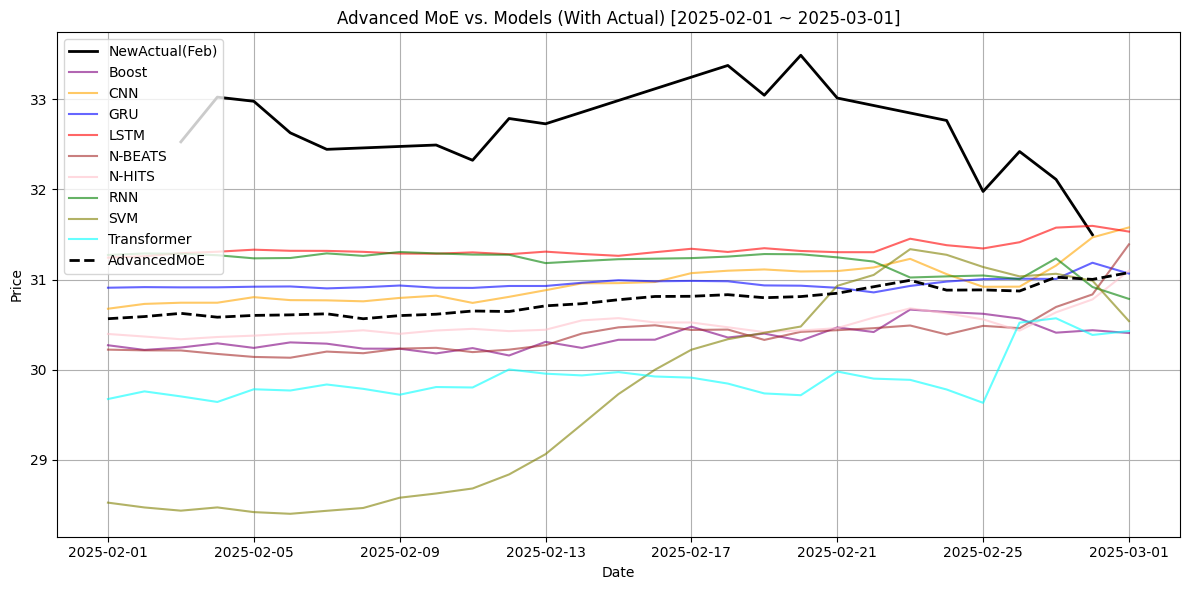

In [5]:
############################################
# Additional Code Snippet:
#  "Advanced MoE vs. Models (With Actual from 'Silver Futures Historical Data_Final Pure Predictions.csv')"
############################################

import pandas as pd
import matplotlib.pyplot as plt

def load_feb_actual_data(csv_file="Silver Futures Historical Data_Final Pure Predictions.csv"):
    """
    Reads the extra CSV file that presumably contains actual price data
    from at least 2025-02-01 onward.
    Returns a DataFrame with columns: ["Date", "Price", (Open, High, Low if present)].
    """
    df_feb = pd.read_csv(csv_file)
    df_feb["Date"] = pd.to_datetime(df_feb["Date"], errors="coerce")
    # remove any extra columns like Vol., Change %
    for col in ["Vol.", "Change %"]:
        if col in df_feb.columns:
            df_feb.drop(columns=[col], errors="ignore", inplace=True)
    # If needed, parse columns
    if "Price" in df_feb.columns:
        df_feb["Price"] = df_feb["Price"].astype(str).str.replace(",", "", regex=True).astype(float)
    # Sort by date
    df_feb.sort_values("Date", inplace=True)
    df_feb.reset_index(drop=True, inplace=True)
    return df_feb

def plot_advanced_moe_vs_models_with_feb_actual(
    final_rolling_fcst,
    df_moe,
    feb_actual_csv="Silver Futures Historical Data_Final Pure Predictions.csv",
    start_plot=pd.to_datetime("2025-02-01"),
    end_plot=pd.to_datetime("2025-03-01")
):
    """
    1) Loads the newly provided 'Silver Futures Historical Data_Final Pure Predictions.csv'
       which presumably contains the actual prices for Feb 2025.
    2) Plots the 9 models' forecast lines, the advanced MoE line, and the actual price from
       that CSV in [start_plot..end_plot].
    """
    # Load the new CSV with actuals
    df_feb_actual = load_feb_actual_data(feb_actual_csv)
    
    # Filter to the same date range
    mask_feb = (df_feb_actual["Date"] >= start_plot) & (df_feb_actual["Date"] <= end_plot)
    df_feb_filtered = df_feb_actual.loc[mask_feb].copy()
    
    # Prepare the forecast data
    df_fc = final_rolling_fcst[
        (final_rolling_fcst["ForecastDate"] >= start_plot) &
        (final_rolling_fcst["ForecastDate"] <= end_plot)
    ].copy()
    
    # Prepare plotting
    plt.figure(figsize=(12,6))

    # color map for the 9 models
    color_map = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }
    
    # 1) Plot the newly revealed actual data in black
    if not df_feb_filtered.empty and "Price" in df_feb_filtered.columns:
        plt.plot(df_feb_filtered["Date"], df_feb_filtered["Price"],
                 color="black", linewidth=2, label="NewActual(Feb)")

    # 2) Plot each model's average line
    for m in df_fc["Model"].unique():
        df_m = df_fc[df_fc["Model"]==m].copy()
        df_m_agg = df_m.groupby("ForecastDate", as_index=False)["Pred_Price_unscaled"].mean()
        c = color_map.get(m, "gray")
        plt.plot(df_m_agg["ForecastDate"], df_m_agg["Pred_Price_unscaled"],
                 color=c, alpha=0.6, label=m)

    # 3) Plot the advanced MoE line
    df_moe_sub = df_moe[
        (df_moe["ForecastDate"] >= start_plot) &
        (df_moe["ForecastDate"] <= end_plot)
    ].copy()
    if not df_moe_sub.empty:
        plt.plot(df_moe_sub["ForecastDate"], df_moe_sub["MOE_Price"],
                 color="black", linestyle="--", linewidth=2, label="AdvancedMoE")

    # Final touches
    plt.title(f"Advanced MoE vs. Models (With Actual) [{start_plot.date()} ~ {end_plot.date()}]")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Usage Example in a new cell:
# 
df_feb_actual = load_feb_actual_data("Silver Futures Historical Data_Final Pure Predictions.csv")
plot_advanced_moe_vs_models_with_feb_actual(
    final_rolling_fcst,
    df_moe_advanced,
    feb_actual_csv="Silver Futures Historical Data_Final Pure Predictions.csv",
    start_plot=pd.to_datetime("2025-02-01"),
    end_plot=pd.to_datetime("2025-03-01")
)
